# Prueba Técnica proceso de selección Banco de Bogotá - Científico Datos Senior

## Problema:

Se requiere crear un agente o un RL (Aprendizaje por Refuerzo) para que entrene/calibre un modelo de ML que pronostique el valor salarial en dólares “salary_in_usd” de diferentes roles/cargos a partir de información relacionada en la base de datos denominada “Base punto 1”. Con lo anterior, se espera que el agente opere dentro de un ciclo de aprendizaje (episodios o pasos) con frecuencia anual (En la hoja “base” se encuentra la variable “work_year”) y en cada proceso interactivo se espera que el agente utilice el modelo de ML productivo de ese paso para entregar la calificación de la base “Pronosticos” con la columna “Llave Pronostico” para que nosotros podamos evaluar la evolución del agente a lo largo del tiempo (“work_year”).

## Interpretación del problema:

Lo que se espera es que se genere un agente que tome una serie de decisiones de que modelo entrenar en cada año de información. Bajo esta premisa, el agente tendrá a su disposición una serie de acciones, donde cada acción representa una configuración distinta de 4 modelos y el agente debe aprender a través del sistema de recompensas, cual configuración de modelo utilizar a fin de minimizar la métrica de error.

En este ejercicio se utilizan 4 modelos diferentes:
* **Regresión Lineal**: sirve como baseline de los demás modelos.
* **Decision Tree**: permite mapear relaciones no lineales y todos los modelos de árboles son particularmente útiles para trabajar con variables categóricas.
* **Random Forest**: reduce el potencial overfitting que se puede encontrar en los modelos de Decision Tree y tiene la particularidad de ser bastante potente en conjuntos de datos pequeños.
* **XGBoost**: junto con LightGBM y CatBoost, suelen ser los modelos que mejor desempeño presentan en datos tabulares (ya que a veces no se cuenta con los datos necesarios para el entrenamiento de una NN). CatBoost es particularmente útil para trabajar con datos categóricos lo que lo hace sumamente fuerte en este escenario donde la mayoría de variables son categóricas. Sin embargo, se realizó su ejecución en un experimento y se encontró que XGBoost tendía a ser más estable y más rápido.

Se entrenará un agente usando el algoritmo **DQN (Deep Q-Learning)** que peermite aproximar los valores Q del tradicional algoritmo de RL Q-Learning. Se utiliza este algoritmo, ya que se realizó una prueba con el algoritmo **A2C (Actor to Critical)** y no se generaron resultados. DQN es particularmente útil en este caso debido a que se manejan muchas posibles accione a seleccionar por parte del agente, y a través del uso de timesteps permite ajustar los pesos de la red neuronal subyacente para seleccionar la política que mejor se ajusta a las observaciones y estados del ambiente.

## Pasos:

* Cargar conjunto de datos y realizar una exploración inicial.
* Realizar preprocesamiento y feature engineering del dataset.
* Generar clase de ambiente de RL.
* Entrenar agente a través de timesteps.
* Evaluar desempeño del agente.
* Predicción base solicitada.
* Aprendizajes finales del modelo y aplicabilidad real.

En este notebook se realizará la parte más interactiva del ejercicio, es decir, se realizará la parte de exploración del conjunto, de revisión de métricas y aplicabilidad. En el script `classes/salary_environment.py` se encuentra el código que contiene la clase del ambiente de RL para el entrenamiento del modelo.

## Librerías

In [ ]:
# Data manipulation and analysis libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from importlib import reload
# Machine Learning libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# Prompting libraries
from openai import OpenAI
# Reinforcement Learning libraries
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

# Local imports
from api import API_KEY
from classes import salary_environment

# Initialize OpenAI client with the API key
client = OpenAI(api_key=API_KEY)

In [89]:
reload(salary_environment)

<module 'classes.salary_environment' from 'd:\\jhoparra\\Repos\\bdb_technical_test\\classes\\salary_environment.py'>

## Variables globales

In [3]:
PROMPT = """
You are a data scientist tasked with analyzing a dataset. The dataset contains various categorical variables.
Your job is to group a lit of categories into broader categories based on their meanings.
Your response must be a JSON object where the key are the categories provided and the value is its corresponding broader group, take the following examples as a reference:
{{
    "US": "North America",
    "FR": "Europe"
}}
{{
    "Machine Learning Engineer": "Machine Learning",
    "Data Scientist": "Data Science",
    "Data Analyst": "Data Analysis",
    "Software Engineer": "Software Development",
}}
Take into account the type of the variable, it could be either a country or an employee role.
The categories are separated by commas.
The variable name is: {variable_type}
The categories are: {list_categories}
Your response:
"""
RANDOM_SEED = 1010

## Funciones

In [4]:
def plot_categorical_variables(data, var):
    """
    Plots the distribution of a categorical variable in the dataset.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing the data.
    var (str): The name of the categorical variable to plot.

    Returns:
    None
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x=var, order=data[var].value_counts().index)
    plt.title(f"Distribution of {var}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [5]:
def aggregate_categories(variable_type, categories, base_prompt=PROMPT):
    """
    Aggregates categories based on the variable type and base prompt.

    Parameters:
    categories (list): List of categories to aggregate.
    variable_type (str): Type of the variable (e.g., "country").
    base_prompt (str): Base prompt with instructions for aggregation.

    Returns:
    list: Aggregated categories.
    """
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": base_prompt.format(variable_type=variable_type, list_categories=", ".join(categories))}
        ],
        temperature=0.0
    )
    return json.loads(response.choices[0].message.content)

In [6]:
def define_model(model, dict_parameters=None):
    """
    Define a machine learning model based on the provided parameters.

    Parameters:
    model (class): The machine learning model class to instantiate.
    dict_parameters (dict, optional): Dictionary of parameters for the model.

    Returns:
    generator: The action to execute.
    """
    if dict_parameters is not None:
        list_values = list(dict_parameters.values())
        # Se va an a generar todas las combinaciones de los valores de los parámetros
        list_combinations = list(product(*list_values))
        for combination in list_combinations:
            dict_parameters_combination = dict(zip(dict_parameters.keys(), combination))
            yield {"base_model": model, "kwargs": dict_parameters_combination}

In [7]:
def get_action(action_to_execute):
    """
    Returns the model initialized to execute based on the provided action.

    Parameters:
    action_to_execute (dict): A dictionary containing the model class and its arguments.

    Returns:
    object: An instance of the base model initialized with the provided parameters.
    """
    base_model = action_to_execute.get("base_model")
    kwargs = action_to_execute.get("kwargs")
    if base_model is None:
        raise ValueError("Action must contain a 'base_model' key.")
    if kwargs is None:
        return base_model()
    else:
        return base_model(**kwargs)

In [145]:
def simulate_steps(base, step_variable, target_variable, list_actions, action_dict, scoring_method="neg_root_mean_squared_error"):
    """
    Simulates the steps of a reinforcement learning environment using the provided base data.

    Parameters:
    base (pd.DataFrame): The input DataFrame containing the data.
    step_variable (str): The variable indicating the step or year in the dataset.
    target_variable (str): The target variable to predict.
    list_actions (list): List of actions to take at each step.
    action_dict (dict): Dictionary mapping years to actions.

    Returns:
    list_rewards (list): List of cross-validation results for each year.
    """
    list_rewards = []
    for year in np.sort(base.work_year.unique()):
        data_year = base[base[step_variable] == year]
        X = data_year.drop(columns=[target_variable, step_variable])
        y = data_year[target_variable]

        # Inicializar el modelo con los datos filtrados
        model = get_action(list_actions[action_dict[year]])

        # Crear OHE para las variables categóricas
        categorical_cols = X.select_dtypes(
            include=["object", "category"]
        ).columns
        if not categorical_cols.empty:
            ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
            # Crear pipeline con OHE si es necesario
            pipeline_model = Pipeline([("ohe", ohe), ("model", model)])
        else:
            # Si no hay variables categóricas, usar el modelo directamente
            pipeline_model = model
        # Realizar validación cruzada para evaluar el modelo
        cv_results = cross_validate(
            pipeline_model, X, y, scoring=scoring_method, cv=3
        )
        reward = -cv_results["test_score"].mean()
        list_rewards.append(reward)
    return list_rewards

## 1. Cargar conjunto de datos y realizar una exploración inicial

### Exploración inicial del dataset

En esta sección el enfoque es familiarizarse con el dataset para definir próximos pasos en el preprocesamiento y posterior modelado.

In [9]:
# Leer archivo
base = pd.read_excel("./files/Base_Prueba_Tecnica_DSS.xlsx", sheet_name="base")
base.head()

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary_in_usd
0,2023,MI,FT,Machine Learning Engineer,US,100,US,M,150000
1,2023,MI,FT,Machine Learning Engineer,US,100,US,M,50000
2,2023,MI,FT,Data Engineer,GB,0,GB,M,73824
3,2023,MI,FT,Data Engineer,GB,0,GB,M,55368
4,2023,SE,FT,Data Science Engineer,US,100,US,M,220000


In [10]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7887 entries, 0 to 7886
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           7887 non-null   int64 
 1   experience_level    7887 non-null   object
 2   employment_type     7887 non-null   object
 3   job_title           7887 non-null   object
 4   employee_residence  7887 non-null   object
 5   remote_ratio        7887 non-null   int64 
 6   company_location    7887 non-null   object
 7   company_size        7887 non-null   object
 8   salary_in_usd       7887 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 554.7+ KB


Ninguna variable tiene datos nulos perse, puede que cuenten con datos nulos codificados con algún valor puntual como -1 o NA.

In [11]:
# Datos por año
base.work_year.value_counts().sort_index()

work_year
2020      36
2021     163
2022    1630
2023    6058
Name: count, dtype: int64

Existen 4 años de información. En general, hay una tendencia donde los años más recientes tienen mayor cantidad de información.

In [12]:
# Imprimir cantidad de categorías en variables categoricas
for col in base.select_dtypes(include=["object"]).columns:
    print(f"{col}: {base[col].nunique()} categorías")

experience_level: 4 categorías
employment_type: 4 categorías
job_title: 116 categorías
employee_residence: 80 categorías
company_location: 70 categorías
company_size: 3 categorías


Se evidencian que hay 3 variables con baja cantidad de categorías (experience_level, employment_type, company_size). Mientras que las variables job_title, employee_residence y company_location tienen múltiples categorías, lo que puede dificultar su procesamiento en un enfoque tradicional de OHE. Para estas categorías se realizará un preprocesamiento para unificar categorías bien sea por una categoría superior o al agrupar categorías con baja frecuencia en una categoría unificada de otros.

In [13]:
# Imprimir categorías más frecuentes
for col in base.select_dtypes(include=["object"]).columns:
    print(f"Hasta top 10 categorías {col}: {', '.join(list(base[col].value_counts().index[:10]))}")

Hasta top 10 categorías experience_level: SE, MI, EN, EX
Hasta top 10 categorías employment_type: FT, CT, FL, PT
Hasta top 10 categorías job_title: Data Engineer, Data Scientist, Data Analyst, Machine Learning Engineer, Applied Scientist, Analytics Engineer, Research Scientist, Data Architect, Data Manager, Research Engineer
Hasta top 10 categorías employee_residence: US, GB, CA, ES, IN, DE, FR, PT, AU, BR
Hasta top 10 categorías company_location: US, GB, CA, ES, DE, IN, FR, AU, PT, BR
Hasta top 10 categorías company_size: M, L, S


No se ven valores extraños. Sin embargo, es claro que no necesariamente el país de residencia es el mismo de la ubicación de la compañía (si los datos no tienen inconsistencias, solo se debería presentar en empleados 100% remotos). Esto se explorará en la siguiente sección.

También se aprecia que es posible que la última palabra del job title, ayude en la creación de una nueva variable y en su categorización.

In [14]:
# Distribución de variables numéricas
base.drop(columns="work_year").describe()

,remote_ratio,salary_in_usd
count,7887.000000,7887.000000
mean,39.603144,149974.480664
std,48.300377,63544.849288
min,0.000000,15000.000000
25%,0.000000,105700.000000
50%,0.000000,143200.000000
75%,100.000000,186450.000000
max,100.000000,430967.000000


Esta distribución de los datos muestra que no hay un sesgo importante de la variable de salario (caso típico en variables de este estilo), ya que la media y la mediana se encuentran relativamente cerca (150k vs 143k respectivamente). Además, se concluye que no tiene datos faltantes (no tiene valores en 0 o -1). Se hace un doble click sobre la variable remote ratio.

In [15]:
# Remote ratio
base.remote_ratio.value_counts().sort_index()

remote_ratio
0      4670
50      187
100    3030
Name: count, dtype: int64

La variable remote ratio solo cuenta con 3 valores únicos, por lo que su comportamiento es más el de una variable categórica al de una variable continua. Sin embargo, se puede interpretrar que la mayoría de los usuarios trabajan presencial vs aquellos que lo hacen a medio tiempo y aquellos completamente remoto.

### Análisis gráfico de las variables

En esta sección se realiza un análisis gráfico inicial de las variables con especial énfasis en variables que necesitan preprocesamiento y en la variable target `salary_in_usd`.

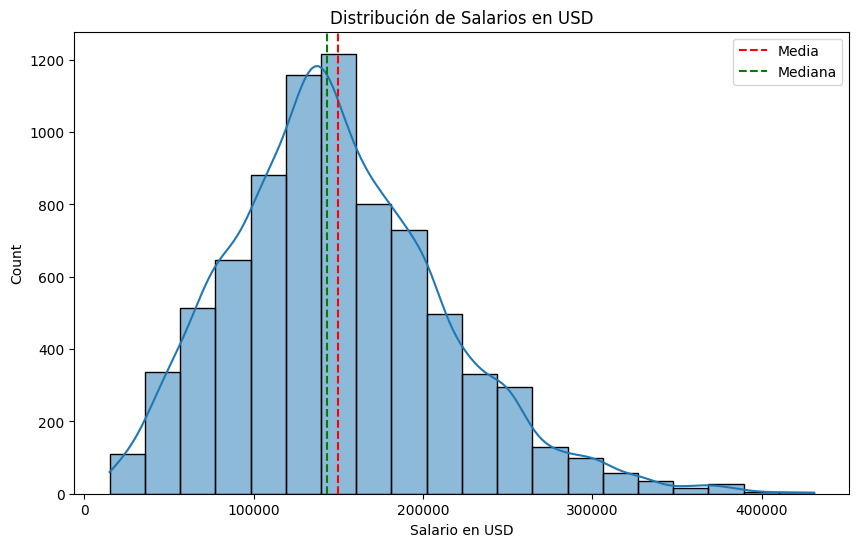

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(base.salary_in_usd, bins=20, kde=True)
plt.title("Distribución de Salarios en USD")
plt.xlabel("Salario en USD")
# Agregar líneas de referencia
plt.axvline(base.salary_in_usd.mean(), color="red", linestyle="--", label="Media")
plt.axvline(base.salary_in_usd.median(), color="green", linestyle="--", label="Mediana")
plt.legend()
plt.show()

Tal y como se planteaba no hay un sesgo importante en la variable, con valores atípicos a la derecha de la distribución. Esto evita un procesamiento adicional en la variable, ya que habría sido necesario realizar una transformación de la variable (como la transformación logarítmica). Se prosigue con el análisis gráfico de las demás variables. Ahora se revisa la evolución de los salarios en cada uno de los años.

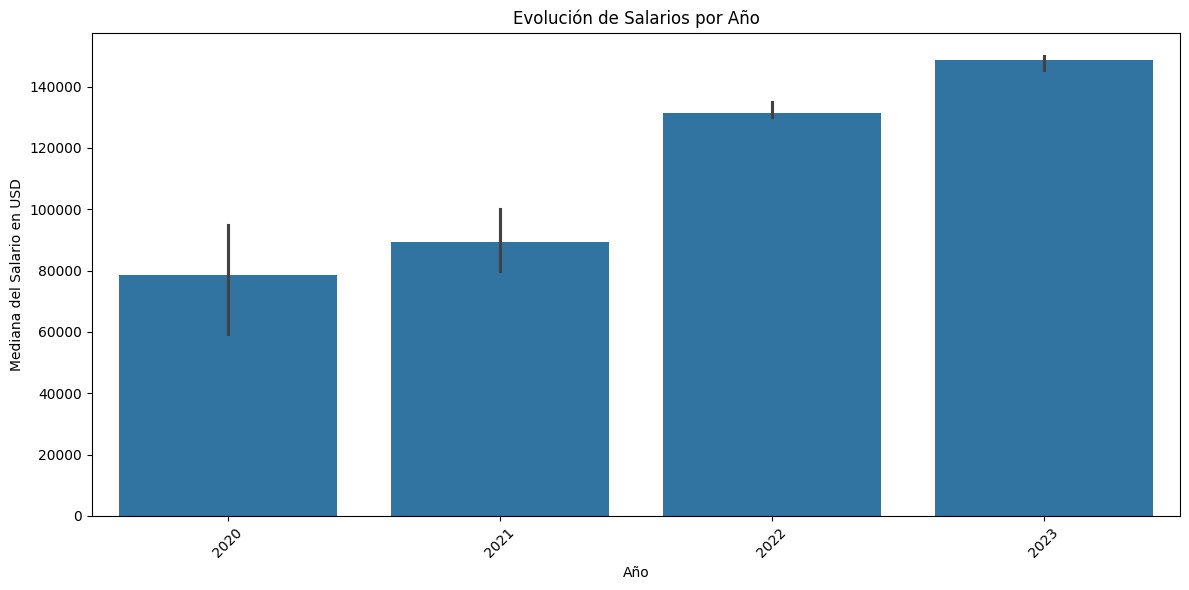

In [17]:
# Evolución de salarios por año
plt.figure(figsize=(12, 6))
sns.barplot(data=base, x="work_year", y="salary_in_usd", estimator="median")
plt.title("Evolución de Salarios por Año")
plt.xlabel("Año")
plt.ylabel("Mediana del Salario en USD")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Arriba se puede ver que la mediana del salario ha incrementado año a año, lo cual tiene mucho sentido tomando en consideración los aumentos anuales por la inflación en cada país. Sería interesante incluir una variable que contemple la inflación por año y país, ya que esto puede agregar mayor ajuste a los cambios de nivel que se ven año a año.

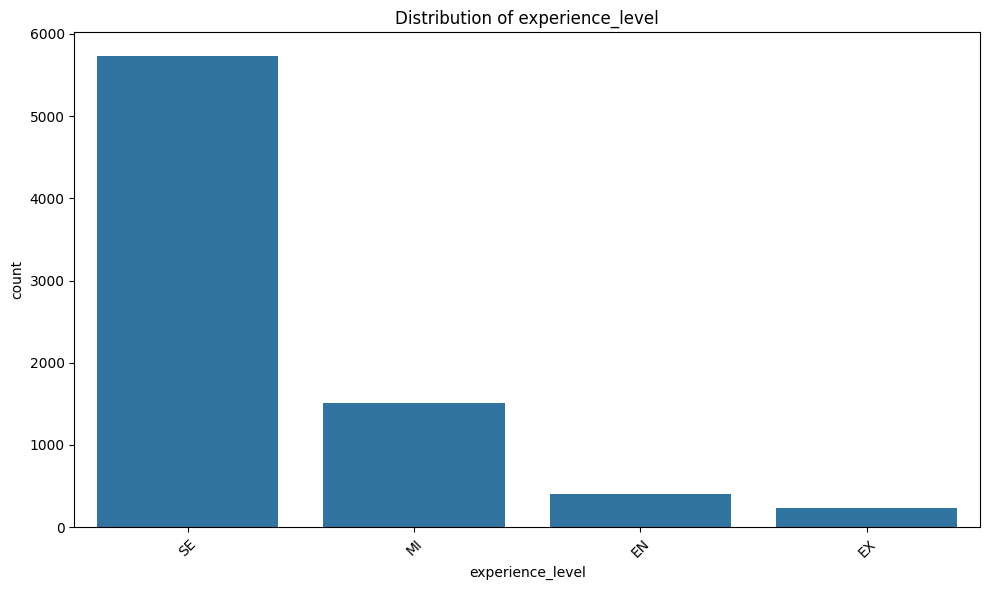

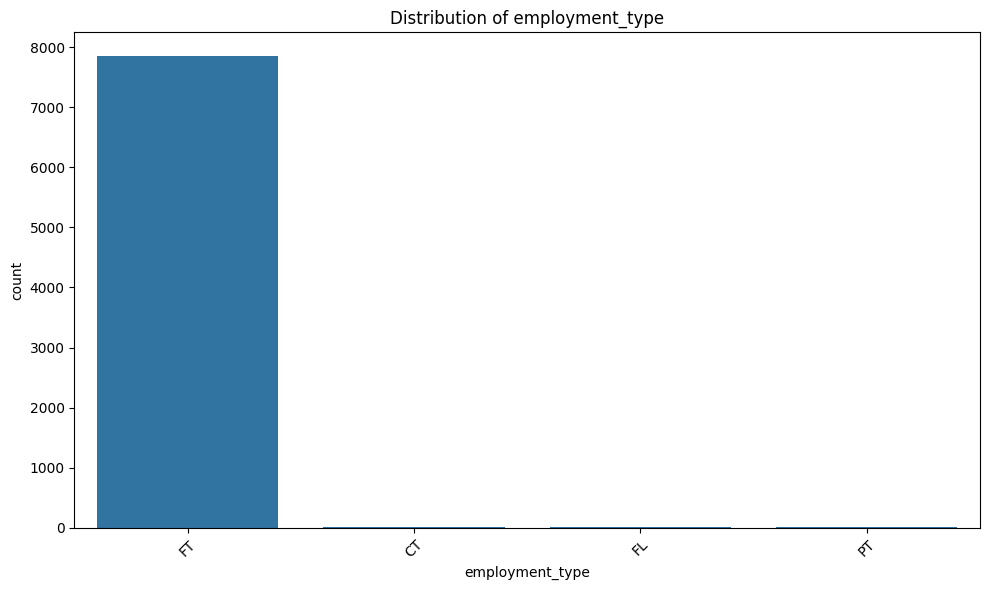

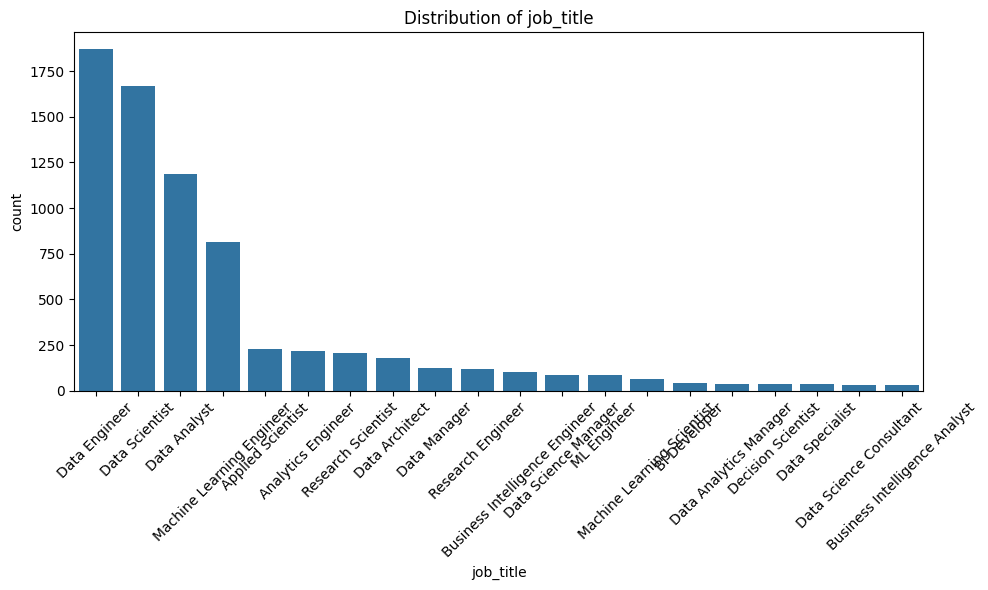

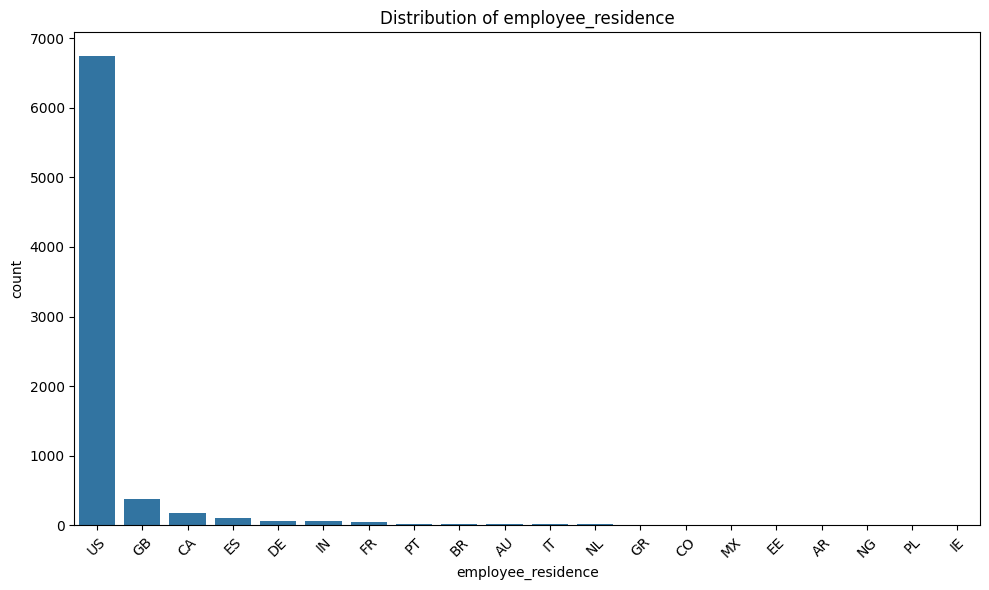

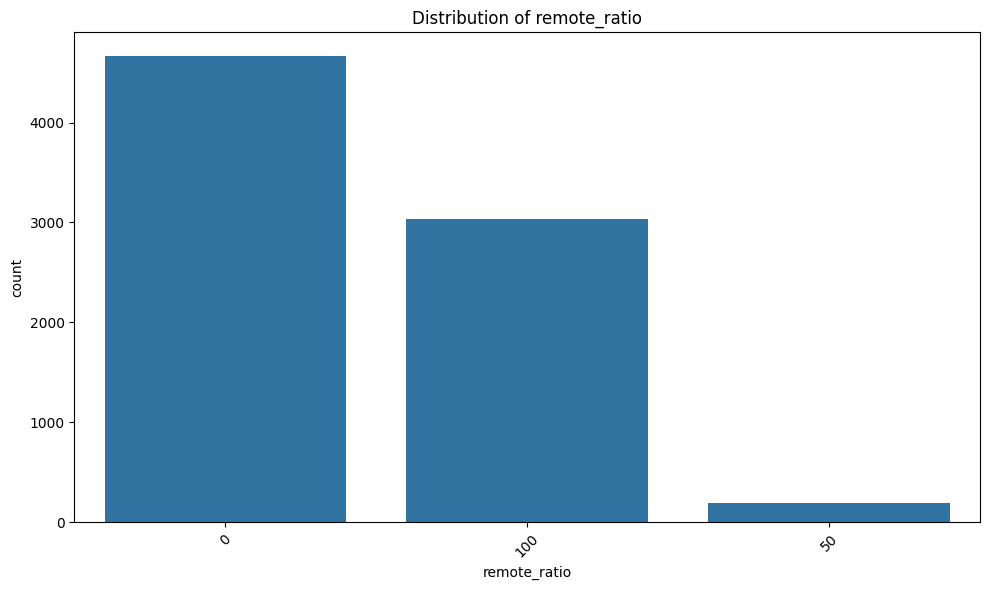

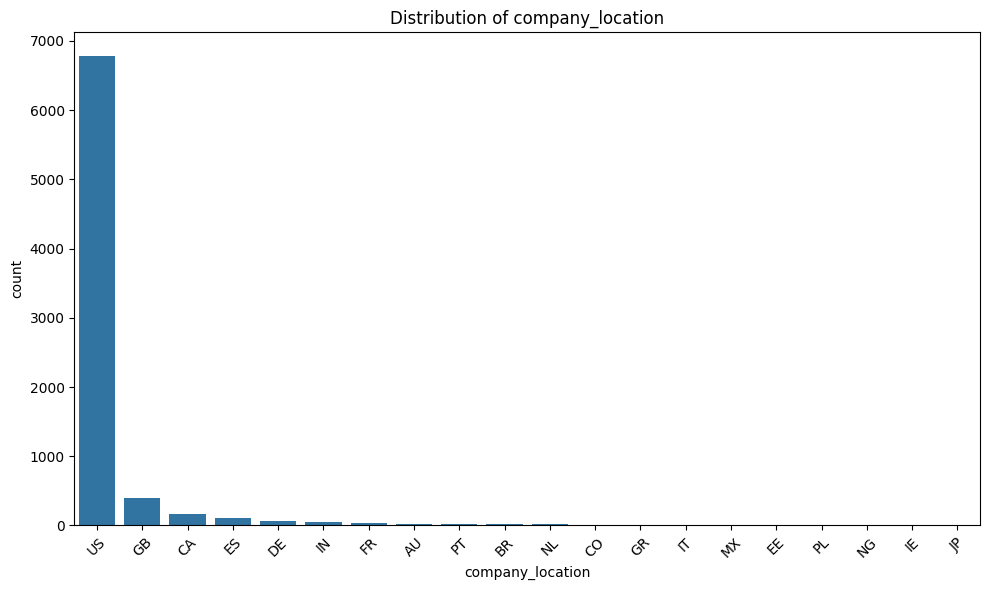

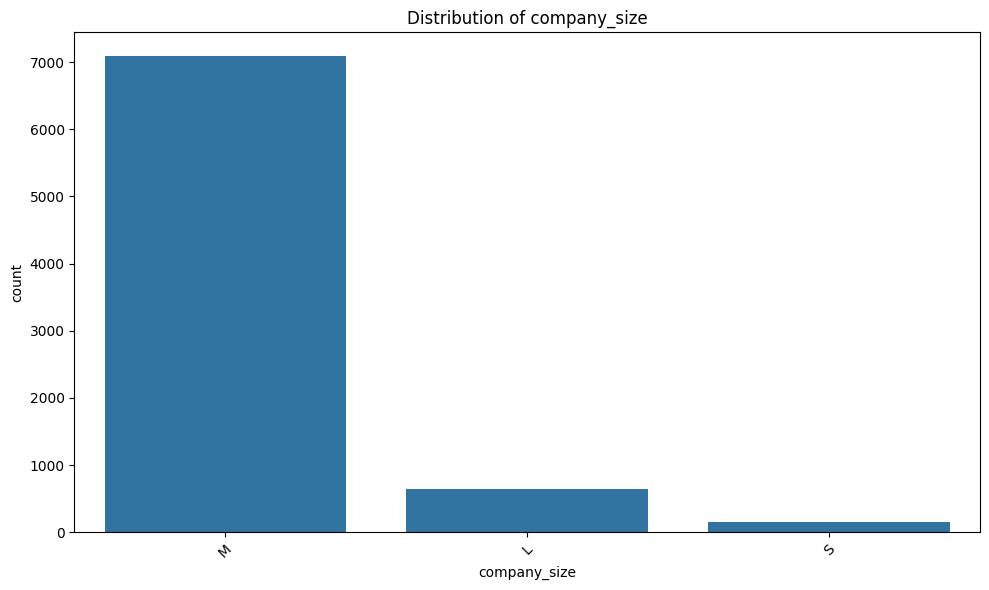

In [18]:
# Graficar variables categóricas
variables = base.drop(columns=["work_year", "salary_in_usd"]).columns
for col in variables:
    unique_values = base[col].nunique()
    if unique_values <= 20:  # Limitar a variables con 10 o menos categorías
        plot_categorical_variables(base, col)
    else:
        filt_categories = list(base[col].value_counts().index[:20])
        plot_categorical_variables(base[base[col].isin(filt_categories)], col)

Conclusiones por gráfica:

* La mayoría de los empleados tiene un nivel **SE** (probablemente indique Senior). Es un comportamiento curioso de la realidad, ya que suelen haber más empleados en roles middle o entry.
* La variable `employment_type` tiene predominancia de una categoría, con cerca del 100% de los roles en la modalidad **FT** (Full Time) en este sentido, esta variable no debería aportar mucha información a la hora de realizar la predicción. Aunque es una variable que en la realidad si debería ser importante a la hora de determinar el salario, en este caso su impacto global en el modelo será mínimo.
* Algo interesante que se aprecia en las gráficas es que el título del cargo definitivamente necesita una estandarización, ya que tenemos casos como **Machine Learning Engineer** y **ML Engineer** que representan aparentemente dos cargos diferentes pero que en la práctica deberían ser el mismo. Este procesamiento se realizará con la ayuda de un LLM donde se le solicitará que unifique los cargos.
* La mayoría de los empleados están ubicados y trabajan para una empresa Estadounidense, se podría intentar dejar solo dos categorías **US** y **Non-US**, ya que la representación de los otros países es baja. La otra alternativa es agruparlo por continente.
* Nada adicional para comentar de la variable `remote_ratio`.
* La mayoría de los empleados trabajan para empresas de tamaño **M** o Medianas.

In [19]:
# Porcentaje de employment type
base.employment_type.value_counts(normalize=True)

employment_type
FT    0.995943
CT    0.001902
FL    0.001141
PT    0.001014
Name: proportion, dtype: float64

Se elimina la variable por ser casi única (tiene más del 99% de los datos concentrados en un único valor).

In [20]:
# Calidad de datos, coincidencia de residencia y trabajo
residence_and_work_match = base.employee_residence == base.company_location
print(residence_and_work_match.mean())
base.remote_ratio[~residence_and_work_match].value_counts()

0.9865601622923799


remote_ratio
100    83
50     19
0       4
Name: count, dtype: int64

En este caso hay un 98% de lo casos donde los empleados viven en el mismo país de la empresa para la que trabajan. Es curioso que 23 personas no trabajan 100% remoto y además no viven en el mismo país de su compañía.

In [21]:
base[["company_location", "employee_residence"]][(~residence_and_work_match) & (base.remote_ratio < 100)].value_counts().sort_index()

company_location  employee_residence
AT                DE                    1
AU                IN                    1
                  NG                    1
BS                AS                    1
CA                US                    1
CN                JE                    1
CZ                PH                    1
DE                US                    1
EE                CY                    1
GB                RO                    1
LU                FR                    1
PL                TR                    1
RO                ES                    1
RU                UZ                    1
SG                IN                    1
US                CA                    1
                  CN                    1
                  CR                    1
                  DE                    1
                  HU                    1
                  IN                    1
                  KW                    1
                  PR                   

Parecen casos aislados de codificación de los datos. Sería importante validar en un escenario real esta información. Ya que la coincidencia es tan alta, se dejará el país de residencia del empleado como variable independiente del modelo y la otra variable se eliminará del conjunto de datos.

Ahora se van a agrupar las variables categóricas en el paso de feature engineering y se sacará el promedio de salario por cada categoría.

## 2. Realizar preprocesamiento y feature engineering del dataset.

En esta sección se elimina la variable con casi 100% de valores únicos y se realiza el agrupamiento de las variables categóricas con más de 5 categorías.

In [22]:
# Eliminar variable con casi 100% de unicidad
base = base.drop(columns=["employment_type", "company_location"])

In [23]:
# Agrupar categorías de país
country_categories = base.employee_residence.unique().tolist()
variable_type = "country"
aggregated_categories = aggregate_categories(variable_type, country_categories)

In [24]:
print(aggregated_categories)

{'US': 'North America', 'GB': 'Europe', 'CA': 'North America', 'GR': 'Europe', 'CO': 'South America', 'PT': 'Europe', 'UA': 'Europe', 'FR': 'Europe', 'NL': 'Europe', 'IN': 'Asia', 'ES': 'Europe', 'LV': 'Europe', 'IT': 'Europe', 'DE': 'Europe', 'PL': 'Europe', 'AM': 'Asia', 'HR': 'Europe', 'TH': 'Asia', 'KR': 'Asia', 'EE': 'Europe', 'TR': 'Asia', 'PH': 'Asia', 'BR': 'South America', 'QA': 'Asia', 'KE': 'Africa', 'RU': 'Europe', 'TN': 'Africa', 'GH': 'Africa', 'AU': 'Oceania', 'BE': 'Europe', 'CH': 'Europe', 'AD': 'Europe', 'EC': 'South America', 'PE': 'South America', 'MX': 'North America', 'MD': 'Europe', 'NG': 'Africa', 'SA': 'Asia', 'NO': 'Europe', 'AR': 'South America', 'EG': 'Africa', 'UZ': 'Asia', 'GE': 'Asia', 'JP': 'Asia', 'ZA': 'Africa', 'HK': 'Asia', 'CF': 'Africa', 'FI': 'Europe', 'IE': 'Europe', 'IL': 'Asia', 'AT': 'Europe', 'SG': 'Asia', 'SE': 'Europe', 'SI': 'Europe', 'KW': 'Asia', 'CY': 'Asia', 'BA': 'Europe', 'RO': 'Europe', 'PK': 'Asia', 'LT': 'Europe', 'IR': 'Asia', 'A

Por lo que pude observar las categorías parecen acorde a lo esperado. Se va a realizar el mapeo.

In [25]:
base["continent_employee"] = base.employee_residence.map(aggregated_categories).fillna("Other")
# Revisar la distribución de continentes
base.continent_employee.value_counts()

continent_employee
North America    6936
Europe            748
Asia              113
South America      47
Africa             22
Oceania            21
Name: count, dtype: int64

Por lo que ahora solo se tienen 6 categorías de esta variable.

Ahora se va a sacar la última palabra del título del rol para ver como quedarían agrupados los cargos.

In [26]:
base["group_job"] = base.job_title.apply(lambda x: x.split()[-1])
base.group_job.value_counts()

group_job
Engineer        3441
Scientist       2262
Analyst         1359
Manager          262
Architect        194
Developer        104
Specialist        59
Science           38
Lead              35
Consultant        35
Data              29
Modeler           20
Strategist        16
Researcher        12
Practitioner       8
Programmer         5
Learning           3
Modeller           2
Technician         2
Management         1
Name: count, dtype: int64

Esta agrupación parece correcta, sin embargo hay algunos casos que podrían agruparse en otras categorías, como **Programmer** con **Developer**. Aún así no parece ser tan exacto y hay algunas incongruencias, por ello se va a pasar por el mismo prompt que se pasó el del país para ver si se obtiene una mejor agrupación de las categorías.

In [27]:
# Agrupar categorías de nombre de cargo
job_categories = base.job_title.unique().tolist()
variable_type = "job title"
aggregated_categories_job = aggregate_categories(variable_type, job_categories)

In [28]:
print(aggregated_categories_job)

{'Machine Learning Engineer': 'Machine Learning', 'Data Engineer': 'Data Engineering', 'Data Science Engineer': 'Data Science', 'Analytics Engineer': 'Data Analysis', 'Data Strategy Manager': 'Data Management', 'Business Intelligence Engineer': 'Business Intelligence', 'Data Analyst': 'Data Analysis', 'Data Manager': 'Data Management', 'Data Scientist': 'Data Science', 'Machine Learning Scientist': 'Machine Learning', 'Data Architect': 'Data Architecture', 'Research Scientist': 'Research', 'Computer Vision Engineer': 'Computer Vision', 'Applied Scientist': 'Applied Science', 'Data Visualization Specialist': 'Data Visualization', 'ML Engineer': 'Machine Learning', 'Research Engineer': 'Research', 'Data Science Manager': 'Data Science', 'BI Analyst': 'Business Intelligence', 'Research Analyst': 'Research', 'Insight Analyst': 'Data Analysis', 'Business Intelligence Analyst': 'Business Intelligence', 'AI Engineer': 'Artificial Intelligence', 'Data Integration Specialist': 'Data Integration

In [29]:
base["group_job_llm"] = base.job_title.map(aggregated_categories_job).fillna("Other")
base.group_job_llm.value_counts()

group_job_llm
Data Science                   1898
Data Engineering               1894
Data Analysis                  1507
Machine Learning               1072
Research                        350
Business Intelligence           236
Applied Science                 226
Data Management                 204
Data Architecture               180
Artificial Intelligence          76
Decision Science                 36
Data Operations                  33
Computer Vision                  30
Data Modeling                    22
ETL                              20
Data Strategy                    16
Data Quality                     15
Natural Language Processing      13
Cloud Computing                  12
Deep Learning                    11
Data Visualization               10
Big Data                          9
Data Integration                  9
Data Development                  6
Autonomous Vehicles               2
Name: count, dtype: int64

Tiene algo más de sentido que la categorización anterior. Se va a probar inicialmente con esta variable y dependiendo del desempeño se podría hacer alguna modificación al prompt, para intentar dividirlo por áreas de trabajo.

In [30]:
base_final = base.drop(columns=["employee_residence", "job_title", "group_job"])
# Mostrar dataset final
base_final.head(5)

,work_year,experience_level,remote_ratio,company_size,salary_in_usd,continent_employee,group_job_llm
0,2023,MI,100,M,150000,North America,Machine Learning
1,2023,MI,100,M,50000,North America,Machine Learning
2,2023,MI,0,M,73824,Europe,Data Engineering
3,2023,MI,0,M,55368,Europe,Data Engineering
4,2023,SE,100,M,220000,North America,Data Science


In [220]:
# Guardar diccionarios de agrupación
with open("./files/aggregated_categories_country.json", "w") as f:
    json.dump(aggregated_categories, f)
with open("./files/aggregated_categories_job.json", "w") as f:
    json.dump(aggregated_categories_job, f)

## 3. Generar clase de ambiente de RL.

Con la definición del ejercicio, se crea una clase con Gymnasium para simular el ambiente de aprendizaje para el agente. Dicha clase está contenida en el archivo `classes/salary_environment.py`. A continuación se describen las principales características del ambiente definido:

* **observación:** es lo que el agente ve del entorno. Para este caso puntual es el promedio del salario, la desviación estándar (que juntos dan una idea de la distribución de la variable) y la cantidad de registros. De esta observación depende la acción que toma el agente en cada paso.
* **acción:** es la acción que ejecuta el agente para obtener una recompensa. Las acciones posibles del agente incluyen múltiples modelos con distintas configuraciones y valores de hiperparámetros. Se espera que el agente aprenda cual acción maximiza la recompensa en cada instante de tiempo.
* **step:** iteración del ambiente. En este caso cada step es un año.
* **recompensa:** el valor que determina la retroalimentación de la acción ejecutada por el agente. Se definió como el `-RMSE` ya que se quieren penalizar en mayor medida los valores con mayor error (no hay datos atípicos en la variable objetivo entonces no le agregará un sesgo importante al modelo).
* **agente:** entidad que toma una acción en el ambiente para maximizar la recompensa. Se entrena un agente a través de múltiples iteraciones para que aprenda una política de acción dependiendo de la observación del ambiente.

En esta sección se define el conjunto de acciones que puede realizar el agente y en la siguiente sección se realiza el ajuste del agente para que aprenda la política de acción.

In [99]:
# Cuando la llave kwargs no es definida se entrena el modelo default
# Inizializar la lista de acciones
list_actions = [
    {"base_model": LinearRegression},
    {"base_model": DecisionTreeRegressor},
    {"base_model": RandomForestRegressor},
    {"base_model": XGBRegressor}
]

En las siguientes celda se agregan modelos adicionales a la lista de acciones, con parámetros específicos para cada modelo.

In [100]:
# Decision Tree con parámetros específicos
dict_parameters = {
    "max_depth": [3, 5, 10],
    "min_samples_split": [2, 5, 10, 25],
    "random_state": [RANDOM_SEED]
}
for action in define_model(DecisionTreeRegressor, dict_parameters):
    list_actions.append(action)

In [101]:
len(list_actions)

16

In [102]:
# Random Forest con parámetros específicos
dict_parameters = {
    "n_estimators": [25, 50, 100],
    "max_depth": [3, 5, 10, 15],
    "min_samples_split": [2, 5, 10, 25],
    "max_features": [0.75, 1.0],
    "random_state": [RANDOM_SEED]
}
for action in define_model(RandomForestRegressor, dict_parameters):
    list_actions.append(action)

In [103]:
len(list_actions)

112

In [104]:
# XGBoost con parámetros específicos
dict_parameters = {
    "n_estimators": [25, 50, 100],
    "max_depth": [3, 5, 10, 15],
    "min_child_weight": [2, 5, 10, 25],
    "subsample": [0.75, 1.0],
    "random_state": [RANDOM_SEED]
}
for action in define_model(XGBRegressor, dict_parameters):
    list_actions.append(action)

In [105]:
len(list_actions)

208

Al final se van a contener 208 acciones posibles que puede seleccionar el agente en cada step. Ahora se va a crear un objeto con la clase definida en el archivo `classes/salary_environment.py`.

In [106]:
base_final.columns

Index(['work_year', 'experience_level', 'remote_ratio', 'company_size',
       'salary_in_usd', 'continent_employee', 'group_job_llm'],
      dtype='object')

In [172]:
# Crear objeto MLSalaryEnvironment
salary_env = salary_environment.MLSalaryEnvironment(actions=list_actions, data=base_final, target_variable="salary_in_usd", step_variable="work_year", cat_features=[0, 2, 3, 4])
# Se evalúa el entorno generado ya que es un entorno personalizado
check_env(salary_env, warn=True)

## 4. Entrenar agente a través de timesteps.

En esta sección se entrenará un agente para que aprenda como interactuar con el ambiente dependiendo de la observación (o estado) que reciba. La idea fundamental es que a través del uso de las acciones disponibles determine la política óptima de interacción con el ambiente. 

Para ello, se van a simular 3000 timesteps, donde el agente va a interactuar con el ambiente y va identificar a través del uso de las recompensas la política óptima (no necesariamente óptima pero es la idea).

A continuación, se define el agente y se corren los timesteps definidos.

In [173]:
agent_salary = DQN("MlpPolicy", salary_env, verbose=1, learning_rate=0.001, exploration_fraction=0.25, exploration_final_eps=0.1, batch_size=64)
agent_salary.learn(total_timesteps=3000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 4         |
|    ep_rew_mean      | -2.06e+05 |
|    exploration_rate | 0.981     |
| time/               |           |
|    episodes         | 4         |
|    fps              | 1         |
|    time_elapsed     | 12        |
|    total_timesteps  | 16        |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 4         |
|    ep_rew_mean      | -2.05e+05 |
|    exploration_rate | 0.962     |
| time/               |           |
|    episodes         | 8         |
|    fps              | 1         |
|    time_elapsed     | 21        |
|    total_timesteps  | 32        |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 4         |
|    e

d:\jhoparra\Repos\bdb_technical_test\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\jhoparra\Repos\bdb_technical_test\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 4         |
|    ep_rew_mean      | -2.06e+05 |
|    exploration_rate | 0.923     |
| time/               |           |
|    episodes         | 16        |
|    fps              | 1         |
|    time_elapsed     | 40        |
|    total_timesteps  | 64        |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 4         |
|    ep_rew_mean      | -2.06e+05 |
|    exploration_rate | 0.904     |
| time/               |           |
|    episodes         | 20        |
|    fps              | 1         |
|    time_elapsed     | 60        |
|    total_timesteps  | 80        |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 4         |
|    ep_rew_mean      | -2.07e+05 |
|    exploration_rate | 0.885     |
| time/               |     

d:\jhoparra\Repos\bdb_technical_test\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\jhoparra\Repos\bdb_technical_test\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 4         |
|    ep_rew_mean      | -2.07e+05 |
|    exploration_rate | 0.443     |
| time/               |           |
|    episodes         | 116       |
|    fps              | 1         |
|    time_elapsed     | 407       |
|    total_timesteps  | 464       |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.29e+04  |
|    n_updates        | 90        |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 4         |
|    ep_rew_mean      | -2.07e+05 |
|    exploration_rate | 0.424     |
| time/               |           |
|    episodes         | 120       |
|    fps              | 1         |
|    time_elapsed     | 418       |
|    total_timesteps  | 480       |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 8.4e

d:\jhoparra\Repos\bdb_technical_test\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\jhoparra\Repos\bdb_technical_test\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\jhoparra\Repos\bdb_technical_test\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\jhoparra\Repos\bdb_technical_test\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\jhoparra\Repos\bd

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 4         |
|    ep_rew_mean      | -2.08e+05 |
|    exploration_rate | 0.1       |
| time/               |           |
|    episodes         | 240       |
|    fps              | 1         |
|    time_elapsed     | 855       |
|    total_timesteps  | 960       |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.08e+04  |
|    n_updates        | 214       |
-----------------------------------


d:\jhoparra\Repos\bdb_technical_test\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\jhoparra\Repos\bdb_technical_test\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\jhoparra\Repos\bdb_technical_test\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\jhoparra\Repos\bdb_technical_test\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\jhoparra\Repos\bdb_t

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 4         |
|    ep_rew_mean      | -2.09e+05 |
|    exploration_rate | 0.1       |
| time/               |           |
|    episodes         | 244       |
|    fps              | 1         |
|    time_elapsed     | 859       |
|    total_timesteps  | 976       |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.1e+04   |
|    n_updates        | 218       |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 4         |
|    ep_rew_mean      | -2.09e+05 |
|    exploration_rate | 0.1       |
| time/               |           |
|    episodes         | 248       |
|    fps              | 1         |
|    time_elapsed     | 869       |
|    total_timesteps  | 992       |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 7.49

d:\jhoparra\Repos\bdb_technical_test\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\jhoparra\Repos\bdb_technical_test\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\jhoparra\Repos\bdb_technical_test\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\jhoparra\Repos\bdb_technical_test\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\jhoparra\Repos\bdb_t

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 4         |
|    ep_rew_mean      | -2.06e+05 |
|    exploration_rate | 0.1       |
| time/               |           |
|    episodes         | 368       |
|    fps              | 1         |
|    time_elapsed     | 1259      |
|    total_timesteps  | 1472      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1e+04     |
|    n_updates        | 342       |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 4         |
|    ep_rew_mean      | -2.05e+05 |
|    exploration_rate | 0.1       |
| time/               |           |
|    episodes         | 372       |
|    fps              | 1         |
|    time_elapsed     | 1288      |
|    total_timesteps  | 1488      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.2e

d:\jhoparra\Repos\bdb_technical_test\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\jhoparra\Repos\bdb_technical_test\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 4         |
|    ep_rew_mean      | -2.05e+05 |
|    exploration_rate | 0.1       |
| time/               |           |
|    episodes         | 544       |
|    fps              | 1         |
|    time_elapsed     | 1965      |
|    total_timesteps  | 2176      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.04e+04  |
|    n_updates        | 518       |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 4         |
|    ep_rew_mean      | -2.05e+05 |
|    exploration_rate | 0.1       |
| time/               |           |
|    episodes         | 548       |
|    fps              | 1         |
|    time_elapsed     | 1974      |
|    total_timesteps  | 2192      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 9.3e

d:\jhoparra\Repos\bdb_technical_test\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\jhoparra\Repos\bdb_technical_test\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 4         |
|    ep_rew_mean      | -2.05e+05 |
|    exploration_rate | 0.1       |
| time/               |           |
|    episodes         | 580       |
|    fps              | 1         |
|    time_elapsed     | 2068      |
|    total_timesteps  | 2320      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.06e+04  |
|    n_updates        | 554       |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 4         |
|    ep_rew_mean      | -2.05e+05 |
|    exploration_rate | 0.1       |
| time/               |           |
|    episodes         | 584       |
|    fps              | 1         |
|    time_elapsed     | 2083      |
|    total_timesteps  | 2336      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.34

d:\jhoparra\Repos\bdb_technical_test\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 4         |
|    ep_rew_mean      | -2.02e+05 |
|    exploration_rate | 0.1       |
| time/               |           |
|    episodes         | 732       |
|    fps              | 1         |
|    time_elapsed     | 2523      |
|    total_timesteps  | 2928      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.05e+04  |
|    n_updates        | 706       |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 4         |
|    ep_rew_mean      | -2.02e+05 |
|    exploration_rate | 0.1       |
| time/               |           |
|    episodes         | 736       |
|    fps              | 1         |
|    time_elapsed     | 2532      |
|    total_timesteps  | 2944      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.29

In [196]:
agent_salary.save("files/salary_agent.zip")

## 5. Evaluar desempeño del agente.
En esta sección se evalúa el desempeño del agente con el ambiente real y se obtienen los modelos entrenados para cada año, así como las recompensas y un breve comparativo contra algunos modelos base para determinar si el agente aprendió correctamente la política que maximiza la recompensa o que minimiza el error en este caso.

In [174]:
# Evaluación del agente y obtención de los modelos entrenados
obs, info = salary_env.reset()
rewards = {}
model_hist = []
action_dict = {}
while True:
    action, _ = agent_salary.predict(obs, deterministic=True)
    action_id = action
    obs, reward, done, _, info = salary_env.step(action)
    model_hist.append(info)
    year = list(info.keys())[0]
    action_dict[year] = action_id
    rewards[year] = reward
    if done:
        break

In [175]:
# Diccionario con el índice de las acciones por año
action_dict

{np.int64(2020): array(54),
 np.int64(2021): array(54),
 np.int64(2022): array(62),
 np.int64(2023): array(109)}

In [176]:
# Diccionario con los modelos entrenados por año
model_hist

[{np.int64(2020): Pipeline(steps=[('ohe',
                   OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
                  ('model',
                   RandomForestRegressor(max_depth=3, max_features=0.75,
                                         min_samples_split=25, n_estimators=50,
                                         random_state=1010))])},
 {np.int64(2021): Pipeline(steps=[('ohe',
                   OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
                  ('model',
                   RandomForestRegressor(max_depth=3, max_features=0.75,
                                         min_samples_split=25, n_estimators=50,
                                         random_state=1010))])},
 {np.int64(2022): Pipeline(steps=[('ohe',
                   OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
                  ('model',
                   RandomForestRegressor(max_depth=5, max_features=0.75,
                                      

In [177]:
# Lista de recompensas obtenidas por el agente (se encuentran en negativo ya que se querían maximizar las recompensas)
rewards

{np.int64(2020): np.float64(-57027.758705372165),
 np.int64(2021): np.float64(-45091.67471939788),
 np.int64(2022): np.float64(-46296.954080063886),
 np.int64(2023): np.float64(-53227.00763500409)}

In [178]:
# Desempeño del modelo de XGBoost default (agente es peor solo en el 2023)
target_variable = "salary_in_usd"
step_variable = "work_year"
rewards_agent = simulate_steps(base_final, step_variable, target_variable, list_actions, action_dict)

In [179]:
# Desempeño de la regresión lineal default (agente es mejor en todos los años)
action_dict_t = {year: 0 for year in np.sort(base_final.work_year.unique())}
rewards_lr = simulate_steps(base_final, step_variable, target_variable, list_actions, action_dict_t)

In [180]:
# Desempeño del modelo de Random Forest default (agente es peor solo en el 2020)
action_dict_t = {year: 2 for year in np.sort(base_final.work_year.unique())}
rewards_rf = simulate_steps(base_final, step_variable, target_variable, list_actions, action_dict_t)

In [181]:
# Desempeño del modelo de XGBoost default (agente es peor solo en el 2023)
action_dict_t = {year: 3 for year in np.sort(base_final.work_year.unique())}
rewards_xgb = simulate_steps(base_final, step_variable, target_variable, list_actions, action_dict_t)

In [182]:
# Tabla comparativa de recompensas
df_rewards = pd.DataFrame({
    "Year": np.sort(base_final.work_year.unique()),
    "Agent": rewards_agent,
    "Linear Regression": rewards_lr,
    "Random Forest": rewards_rf,
    "XGBoost": rewards_xgb
})
df_rewards.round(2)

,Year,Agent,Linear Regression,Random Forest,XGBoost
0,2020,57027.76,94010.21,57628.00,61154.92
1,2021,45076.43,43833.51,46456.94,50244.62
2,2022,46552.65,47087.86,47873.86,48454.55
3,2023,54312.61,54312.94,54602.87,54369.76


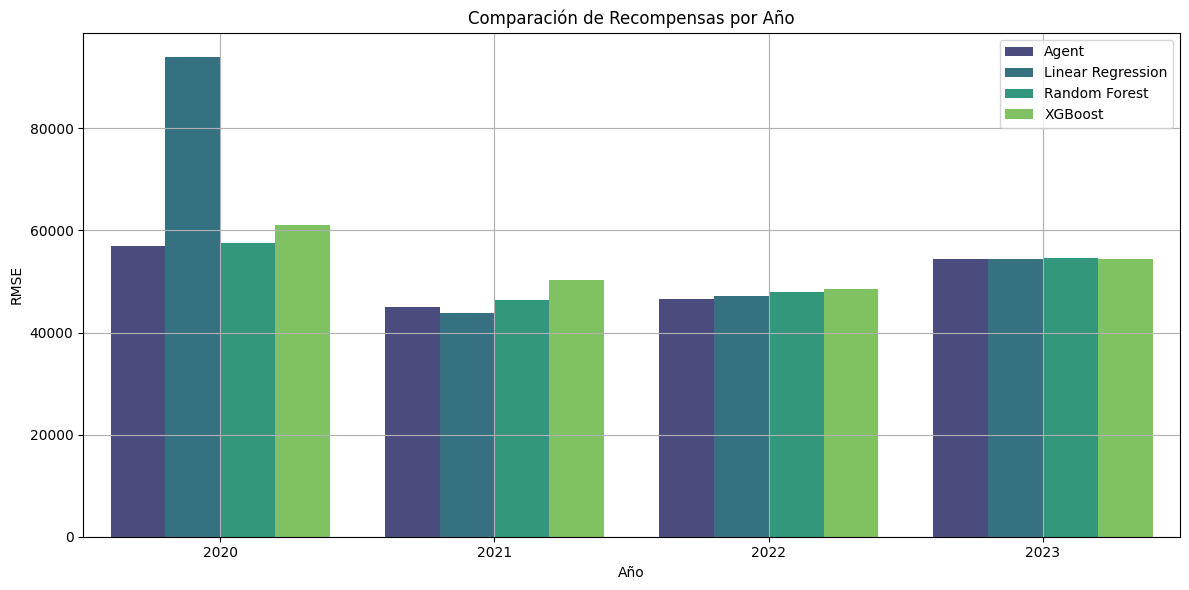

In [195]:
# Graficar resultados
df_melted = df_rewards.melt(id_vars="Year", var_name="Model", value_name="Reward")
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="Year", y="Reward", hue="Model", palette="viridis")
plt.title("Comparación de Recompensas por Año")
plt.xlabel("Año")
plt.ylabel("RMSE")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Se ve que la política seleccionada por el agente tiene sentido, ya que en 11 de las 12 comparaciones realizadas tanto con la regresión lineal default, random forest default y XGBoost default, el desempeño del modelo escogido por el agente es mejor al desempeño mostrado por los modelos default en la validación cruzada con 3 folds. Para complementar se va a obtener la comparativa de métricas con el MAPE (Mean Avarage Percantage Error).

In [183]:
# Desempeño del modelo de XGBoost default (agente es peor solo en el 2023)
target_variable = "salary_in_usd"
step_variable = "work_year"
scoring_method = "neg_mean_absolute_percentage_error"
rewards_agent = simulate_steps(base_final, step_variable, target_variable, list_actions, action_dict, scoring_method=scoring_method)

In [184]:
# Desempeño de la regresión lineal default (agente es mejor en todos los años)
action_dict_t = {year: 0 for year in np.sort(base_final.work_year.unique())}
rewards_lr = simulate_steps(base_final, step_variable, target_variable, list_actions, action_dict_t, scoring_method=scoring_method)

In [185]:
# Desempeño del modelo de Random Forest default (agente es peor solo en el 2020)
action_dict_t = {year: 2 for year in np.sort(base_final.work_year.unique())}
rewards_rf = simulate_steps(base_final, step_variable, target_variable, list_actions, action_dict_t, scoring_method=scoring_method)

In [186]:
# Desempeño del modelo de XGBoost default (agente es peor solo en el 2023)
action_dict_t = {year: 3 for year in np.sort(base_final.work_year.unique())}
rewards_xgb = simulate_steps(base_final, step_variable, target_variable, list_actions, action_dict_t, scoring_method=scoring_method)

In [187]:
# Tabla comparativa de recompensas
df_rewards_mape = pd.DataFrame({
    "Year": np.sort(base_final.work_year.unique()),
    "Agent": rewards_agent,
    "Linear Regression": rewards_lr,
    "Random Forest": rewards_rf,
    "XGBoost": rewards_xgb
})
df_rewards_mape.round(3)

,Year,Agent,Linear Regression,Random Forest,XGBoost
0,2020,0.532,0.702,0.445,0.414
1,2021,0.527,0.512,0.463,0.477
2,2022,0.345,0.350,0.350,0.346
3,2023,0.318,0.321,0.318,0.317


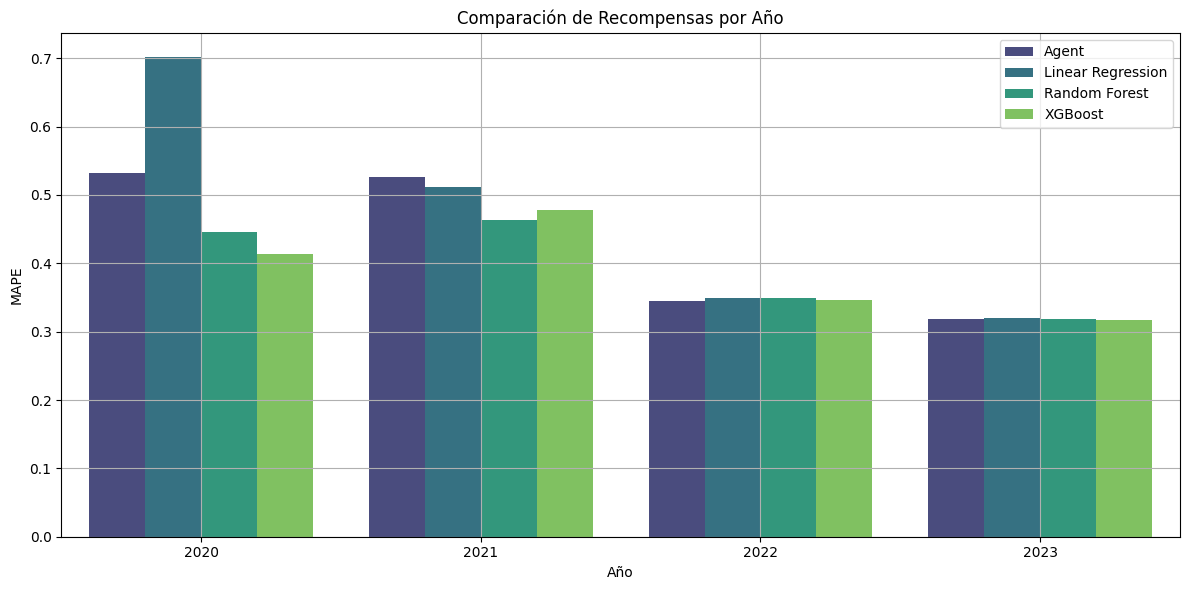

In [192]:
# Graficar resultados
df_melted = df_rewards_mape.melt(id_vars="Year", var_name="Model", value_name="Reward")
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="Year", y="Reward", hue="Model", palette="viridis")
plt.title("Comparación de Recompensas por Año")
plt.xlabel("Año")
plt.ylabel("MAPE")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

En estos datos se ve que el modelo generado tiene un resultado consistente. Si bien no es el mejor en todos los escenarios, disminuye con el paso de los años y no presenta una alta volatilidad como los modelos de random forest y Xgboost default.

Así mismo, es importante analizar distintas configuraciones de la ingeniería de características a fin de minimizar aún más el error de los modelos. En este caso, se dejaron las variables agrupadas en vez de las variables originales ya que permiten una mayor generalización del modelo al no incluir tantas categorías con baja frecuencia.

## 6. Predicción base solicitada.

A continuación, se realiza la predicción de la base solicitada para enviar el dataset con la calificación de los registros con la variable "Llave pronóstico". Para realizar esta predicción se realiza el mismo procesamiento que se realizó en el dataset base y luego se realiza la predicción por año, asegurando usar el modelo entrenado en ese año puntual para generar la predicción.

Para finalizar, se hacen unas validaciones de datos nulos y de la distribución del salario estimado para ver que todo funcione según lo esperado.

In [211]:
# Cargar datos de pronóstico
forecast_data = pd.read_excel("./files/Base_Prueba_Tecnica_DSS.xlsx", sheet_name="Pronosticos")

In [212]:
forecast_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Llave Pronostico    115 non-null    int64 
 1   work_year           115 non-null    int64 
 2   experience_level    115 non-null    object
 3   employment_type     115 non-null    object
 4   job_title           115 non-null    object
 5   employee_residence  115 non-null    object
 6   remote_ratio        115 non-null    int64 
 7   company_location    115 non-null    object
 8   company_size        115 non-null    object
dtypes: int64(3), object(6)
memory usage: 8.2+ KB


In [213]:
# Datos por año
forecast_data.work_year.value_counts().sort_index()

work_year
2020    39
2021    55
2022    20
2023     1
Name: count, dtype: int64

In [214]:
# Realizar preprocesamiento realizado para el dataset base
forecast_data["continent_employee"] = forecast_data.employee_residence.map(aggregated_categories).fillna("Other")
forecast_data["group_job_llm"] = forecast_data.job_title.map(aggregated_categories_job).fillna("Other")

In [215]:
forecast_data.head()

,Llave Pronostico,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,continent_employee,group_job_llm
0,1,2020,EN,FT,Azure Data Engineer,MU,0,MU,S,Other,Cloud Computing
1,2,2020,EN,CT,Staff Data Analyst,CA,50,CA,L,North America,Data Analysis
2,3,2022,EN,FT,Research Engineer,RU,100,RU,M,Europe,Research
3,4,2020,SE,FT,Staff Data Scientist,US,50,US,M,North America,Data Science
4,5,2020,EX,FT,Managing Director Data Science,US,100,US,L,North America,Other


In [ ]:
list_df = []
for idx, year in enumerate(np.sort(base_final.work_year.unique())):
    print(f"Año: {year}")
    # Filtrar datos de pronóstico para el año actual
    temp_forecast_data = forecast_data[forecast_data.work_year == year]
    # Asegurarse de que las columnas coincidan con el modelo entrenado y realizar predicción
    y_forecast = model_hist[idx][year].predict(temp_forecast_data[base_final.drop(columns=["work_year", "salary_in_usd"]).columns])
    # Agregar la columna de predicción al DataFrame temporal
    temp_forecast_data["predicted_salary"] = y_forecast
    list_df.append(temp_forecast_data)

forecast_results = pd.concat(list_df, ignore_index=True)

In [217]:
# Dataset de resultados de pronóstico
forecast_results[["Llave Pronostico", "predicted_salary"]].head()

,Llave Pronostico,predicted_salary
0,1,89909.700001
1,2,91929.838766
2,4,91929.838766
3,5,101171.020433
4,7,89909.700001


In [218]:
# Revisar no tener valores nulos
forecast_results.predicted_salary.isna().value_counts()

predicted_salary
False    115
Name: count, dtype: int64

In [219]:
# Validación de salario promedio por año
forecast_results.groupby("work_year")["predicted_salary"].describe()

,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,39.0,90770.539169,3538.188271,87306.481207,87306.481207,90629.133707,91929.838766,101171.020433
2021,55.0,93529.718648,38177.585418,56519.682287,60791.483516,70943.161365,118150.224240,165900.047354
2022,20.0,141297.055070,43610.250364,55197.597149,123099.557225,158527.033651,158904.995792,219244.095871
2023,1.0,70609.484200,NaN,70609.484200,70609.484200,70609.484200,70609.484200,70609.484200


In [171]:
# Exportar resultados a csv
forecast_results[["Llave Pronostico", "predicted_salary"]].to_csv("./files/forecast_results.csv", index=False)

Viendo la distribución de las predicciones no se ve un comportamiento extraño. Por ello se procede a imprimir la importancia de las características de los modelos resultantes y unas conclusiones finales.

## 7. Aprendizajes finales del modelo y aplicabilidad real.

Para finalizar el ejercicio, se obtiene la importancia de las características en cada modelo para determinar las variables que más influyen en la respuesta. Así mismo se definen algunos escenarios de aplicabilidad del ejercicio realizado y del modelo generado para dar una visión más general de potenciales próximos pasos.

In [221]:
model_hist

[{np.int64(2020): Pipeline(steps=[('ohe',
                   OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
                  ('model',
                   RandomForestRegressor(max_depth=3, max_features=0.75,
                                         min_samples_split=25, n_estimators=50,
                                         random_state=1010))])},
 {np.int64(2021): Pipeline(steps=[('ohe',
                   OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
                  ('model',
                   RandomForestRegressor(max_depth=3, max_features=0.75,
                                         min_samples_split=25, n_estimators=50,
                                         random_state=1010))])},
 {np.int64(2022): Pipeline(steps=[('ohe',
                   OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
                  ('model',
                   RandomForestRegressor(max_depth=5, max_features=0.75,
                                      

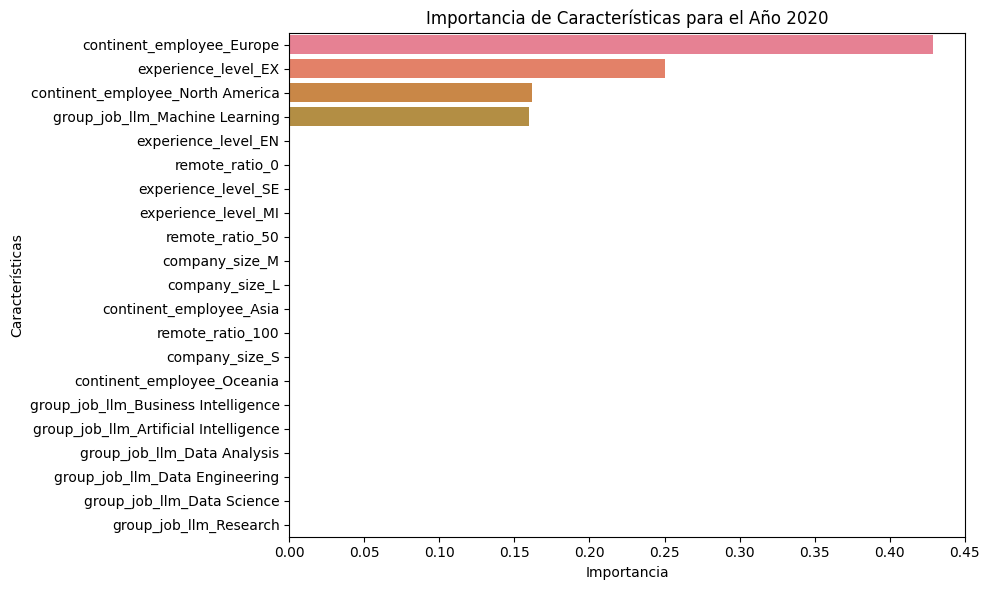

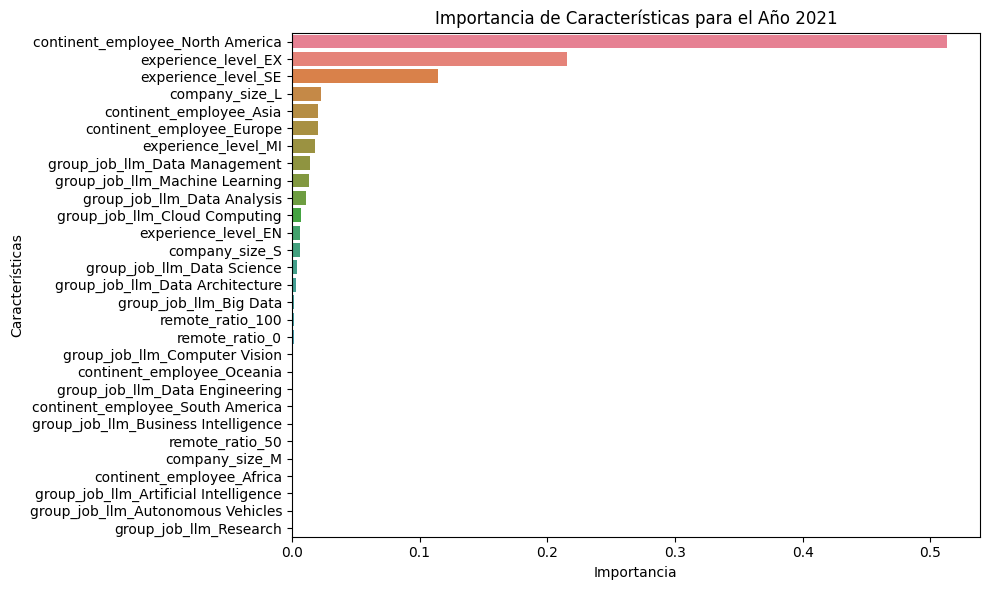

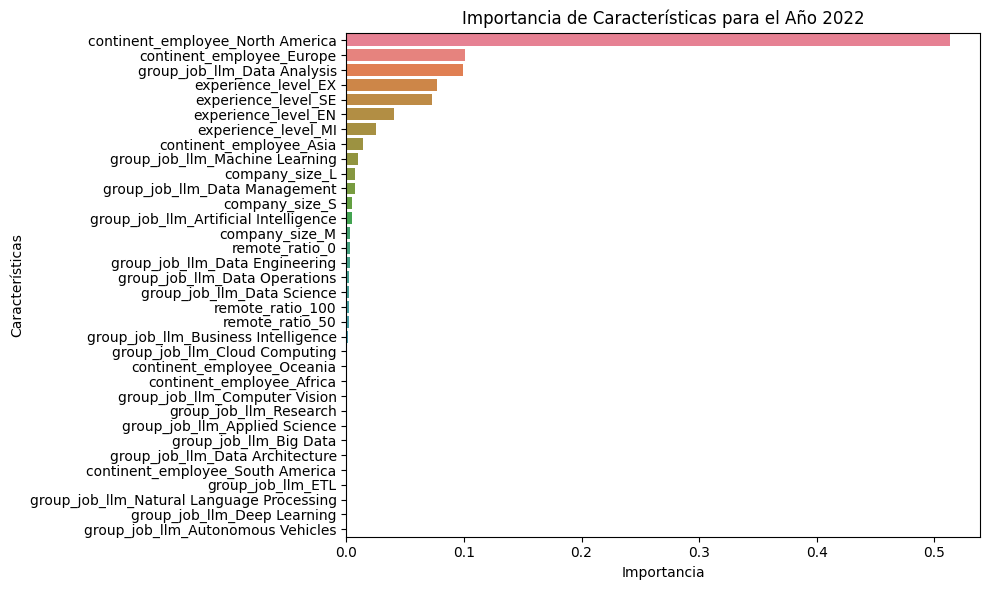

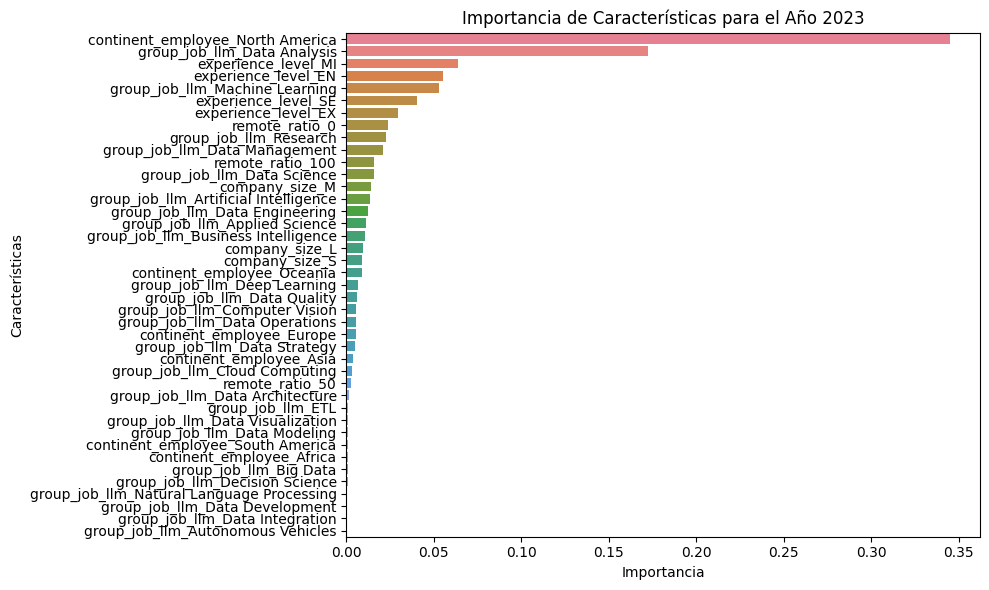

In [238]:
for idx, year in enumerate(np.sort(base_final.work_year.unique())):
    # usar el modelo entrenado para el año específico
    model = model_hist[idx][year][1]
    ohe = model_hist[idx][year][0]
    dict_feature_importances = dict(zip(ohe.get_feature_names_out(), model.feature_importances_))
    data_feature_importances = pd.DataFrame.from_dict(dict_feature_importances, orient="index", columns=["importance"]).sort_values(by="importance", ascending=False).reset_index(names="feature")
    # Graficar las importancias de las características
    plt.figure(figsize=(10, 6))
    sns.barplot(data=data_feature_importances,x="importance", y="feature", hue="feature")
    plt.title(f"Importancia de Características para el Año {year}")
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.tight_layout()
    plt.show()

* En la última gráfica se observa que la variable más relevante es el continente del empleado, con cerca del 35% del total de la contribución en el modelo.
* Así mismo, la segunda variable más relevante es si el empleado pertenece al área de Data Analysis.
* Se ve que conforme se tienen más datos el modelo deja de depender fuertemente de una única variable.

In [244]:
# Promedio de salario en 2023 por continente
base_final[base_final.work_year == 2023].groupby("continent_employee").agg(count=("salary_in_usd", "size"), mean=("salary_in_usd", "mean")).sort_values(by="mean",ascending=False)

,count,mean
continent_employee,,
Oceania,10,200697.300000
North America,5488,161868.975036
Europe,469,102622.430704
South America,27,66472.888889
Asia,50,61220.320000
Africa,14,53208.142857


El continente que mayor promedio de ingresos tiene es Oceanía seguido de Norte América. Por lo que su contribución al modelo es clara, y modifica el nivel de ingresos con respecto a otros continentes.

In [243]:
# Promedio de salario en 2023 por continente
base_final[base_final.work_year == 2023].groupby("group_job_llm").agg(count=("salary_in_usd", "size"), mean=("salary_in_usd", "mean")).sort_values(by="mean",ascending=False)

,count,mean
group_job_llm,,
Deep Learning,9,208333.666667
Computer Vision,20,195170.000000
Applied Science,208,189935.754808
Machine Learning,867,189146.839677
Research,333,180800.780781
Data Science,1364,167394.395161
Decision Science,36,165691.555556
Data Architecture,130,161303.692308
Artificial Intelligence,64,158697.515625


Data Analysis en este caso es el área de empleados que menos gana con respecto a los grupos grandes (más de 100 empleados). Por lo que se concluye que cuando el empleado pertenece a esta área su nivel de ingresos se estima menor por parte del modelo.

### Conclusiones

* El agente entrenado permite decidir que modelo se debería entrenar en cada iteración y en la mayoría de los casos es un modelo con buen desempeño.
* Este agente permite automatizar el flujo de trabajo para escenarios con alto flujo de datos y alto data drift, por lo que representa una alternativa para mantener el modelo actualizado.
* Se recomienda realizar mayor ingeniería de características y complementar con información macroeconómica para tener mejores predicciones.
* Probar con más acciones como preprocesamiento, modelos adicionales, otras observaciones y otras recompensas.